<a href="https://colab.research.google.com/github/kfahn22/Colab_notebooks/blob/main/stable_diffusion_xl_demo_2_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[stable-diffusion-xl-demo](https://github.com/TonyLianLong/stable-diffusion-xl-demo/blob/main/app.py)

In [1]:
!pip install -q diffusers gradio safetensors accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 9.2 MB/s 

In [2]:
from torch.nn import DataParallel

class UNetDataParallel(DataParallel):
    def forward(self, *inputs, **kwargs):
        # This is because the timestep (inputs[1]) in UNet is a 0-d tensor and scatter will try to split inputs[1]. We simply convert it to a float so that scatter has no effect on it.

        inputs = inputs[0], inputs[1].item()
        return super().forward(*inputs, **kwargs)

In [3]:
import gradio as gr

from diffusers import DiffusionPipeline, LCMScheduler
import torch

import base64
from io import BytesIO
import os
import gc
import warnings
#from helper.py import UNetDataParallel
#from share_btn import community_icon_html, loading_icon_html, share_js
# SDXL code: https://github.com/huggingface/diffusers/pull/3859

# Process environment variables
# Use `segmind/SSD-1B` (distilled SDXL) for faster generation.
use_ssd = os.getenv("USE_SSD", "false").lower() == "true"
if use_ssd:
    model_key_base = "segmind/SSD-1B"
    model_key_refiner = "stabilityai/stable-diffusion-xl-refiner-1.0"
    lcm_lora_id = "latent-consistency/lcm-lora-ssd-1b"
else:
    model_key_base = "stabilityai/stable-diffusion-xl-base-1.0"
    model_key_refiner = "stabilityai/stable-diffusion-xl-refiner-1.0"
    lcm_lora_id = "latent-consistency/lcm-lora-sdxl"

# Use LCM LoRA (enabled by default)
if "ENABLE_LCM" not in os.environ:
    warnings.warn("`ENABLE_LCM` environment variable is not set. LCM LoRA will be loaded by default and refiner will be disabled by default. You can set it to `False` to turn off LCM LoRA.")

enable_lcm = os.getenv("ENABLE_LCM", "true").lower() == "true"
# Use refiner (disabled by default if LCM is enabled)
enable_refiner = os.getenv("ENABLE_REFINER", "false" if enable_lcm or use_ssd else "true").lower() == "true"
# Output images before the refiner and after the refiner
output_images_before_refiner = os.getenv("OUTPUT_IMAGES_BEFORE_REFINER", "false").lower() == "true"

offload_base = os.getenv("OFFLOAD_BASE", "false").lower() == "true"
offload_refiner = os.getenv("OFFLOAD_REFINER", "true").lower() == "true"

# Generate how many images by default
default_num_images = int(os.getenv("DEFAULT_NUM_IMAGES", "1"))
if default_num_images < 1:
    default_num_images = 1

# Create public link
#share = os.getenv("SHARE", "false").lower() == "true"

print("Loading model", model_key_base)
pipe = DiffusionPipeline.from_pretrained(model_key_base, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

if enable_lcm:
    pipe.load_lora_weights(lcm_lora_id)
    pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

multi_gpu = os.getenv("MULTI_GPU", "false").lower() == "true"

if multi_gpu:
    pipe.unet = UNetDataParallel(pipe.unet)
    pipe.unet.config, pipe.unet.dtype, pipe.unet.add_embedding = pipe.unet.module.config, pipe.unet.module.dtype, pipe.unet.module.add_embedding
    pipe.to("cuda")
else:
    if offload_base:
        pipe.enable_model_cpu_offload()
    else:
        pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

# pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

if enable_refiner:
    print("Loading model", model_key_refiner)
    pipe_refiner = DiffusionPipeline.from_pretrained(model_key_refiner, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
    if multi_gpu:
        pipe_refiner.unet = UNetDataParallel(pipe_refiner.unet)
        pipe_refiner.unet.config, pipe_refiner.unet.dtype, pipe_refiner.unet.add_embedding = pipe_refiner.unet.module.config, pipe_refiner.unet.module.dtype, pipe_refiner.unet.module.add_embedding
        pipe_refiner.to("cuda")
    else:
        if offload_refiner:
            pipe_refiner.enable_model_cpu_offload()
        else:
            pipe_refiner.to("cuda")

    # if using torch < 2.0
    # pipe_refiner.enable_xformers_memory_efficient_attention()

    # pipe_refiner.unet = torch.compile(pipe_refiner.unet, mode="reduce-overhead", fullgraph=True)

# NOTE: we do not have word list filtering in this gradio demo

is_gpu_busy = False
def infer(prompt, negative, scale, samples=1, steps=50, refiner_strength=0.3, seed=-1):
    prompt, negative = [prompt] * samples, [negative] * samples

    g = torch.Generator(device="cuda")
    if seed != -1:
        g.manual_seed(seed)
    else:
        g.seed()

    images_b64_list = []

    if not enable_refiner or output_images_before_refiner:
        images = pipe(prompt=prompt, negative_prompt=negative, guidance_scale=scale, num_inference_steps=steps, generator=g).images
    else:
        # This skips the decoding and re-encoding for refinement.
        images = pipe(prompt=prompt, negative_prompt=negative, guidance_scale=scale, num_inference_steps=steps, output_type="latent", generator=g).images

    gc.collect()
    torch.cuda.empty_cache()

    if enable_refiner:
        if output_images_before_refiner:
            for image in images:
                buffered = BytesIO()
                image.save(buffered, format="JPEG")
                img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

                image_b64 = (f"data:image/jpeg;base64,{img_str}")
                images_b64_list.append(image_b64)

        images = pipe_refiner(prompt=prompt, negative_prompt=negative, image=images, num_inference_steps=steps, strength=refiner_strength, generator=g).images

        gc.collect()
        torch.cuda.empty_cache()

    for image in images:
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

        image_b64 = (f"data:image/jpeg;base64,{img_str}")
        images_b64_list.append(image_b64)

    return images_b64_list



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

<ipython-input-3-3a6413ee9bbe>:29: UserWarning: `ENABLE_LCM` environment variable is not set. LCM LoRA will be loaded by default and refiner will be disabled by default. You can set it to `False` to turn off LCM LoRA.
  warnings.warn("`ENABLE_LCM` environment variable is not set. LCM LoRA will be loaded by default and refiner will be disabled by default. You can set it to `False` to turn off LCM LoRA.")


Loading model stabilityai/stable-diffusion-xl-base-1.0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [18]:
prompt = 'A very colorful cocker spaniel'
neg_prompt = 'low quality'

image = infer(prompt, neg_prompt, 1, 1, 50, 0.3, -1)

  0%|          | 0/50 [00:00<?, ?it/s]

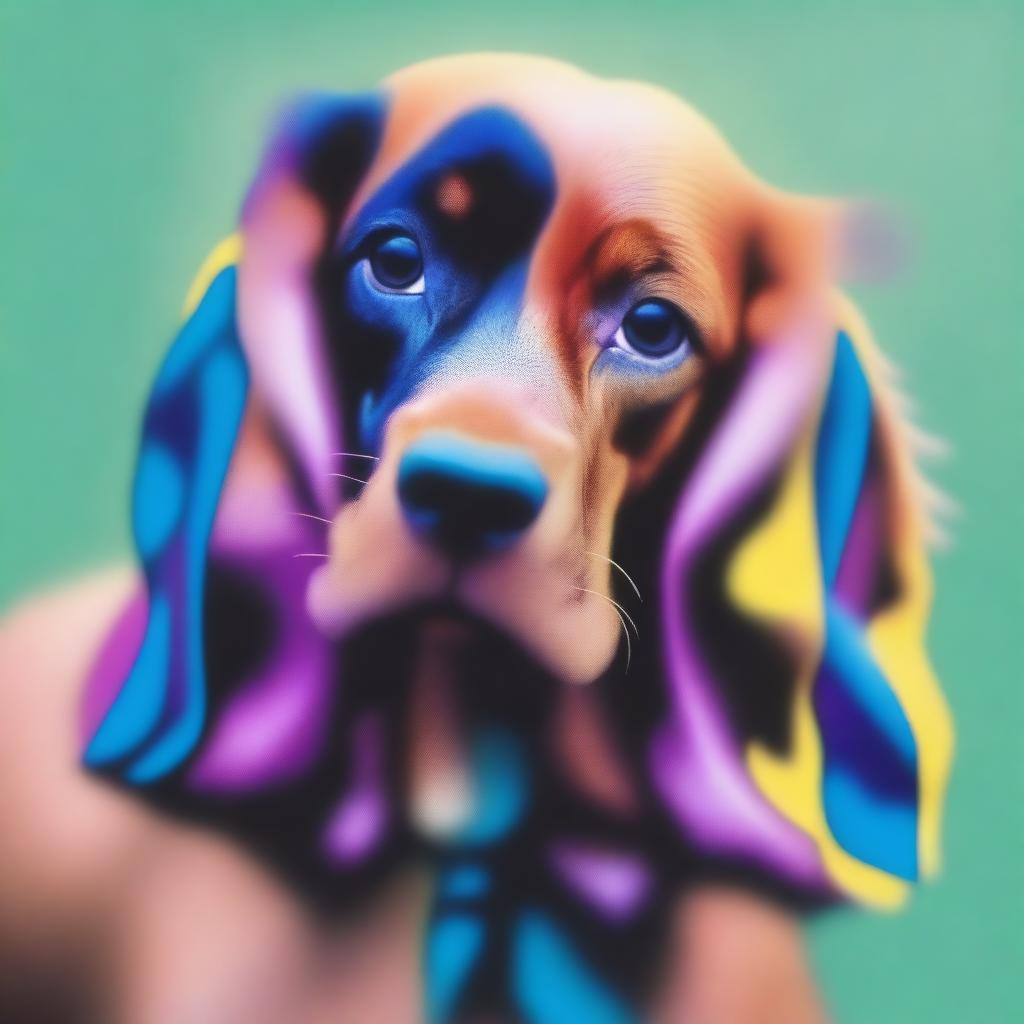

In [19]:
import os
#import requests
from PIL import Image
from io import BytesIO
import base64
import re

from PIL import Image

image_data = re.sub('^data:image/.+;base64,', '', image[0])
Image.open(BytesIO(base64.b64decode(image_data)))


## Gradio interface

In [ ]:
# Reference: https://huggingface.co/spaces/google/sdxl/blob/main/app.py#L139
css = """
        .gradio-container {
            font-family: 'IBM Plex Sans', sans-serif;
        }
        .gr-button {
            color: white;
            border-color: black;
            background: black;
        }
        input[type='range'] {
            accent-color: black;
        }
        .dark input[type='range'] {
            accent-color: #dfdfdf;
        }
        .gradio-container {
            max-width: 730px !important;
            margin: auto;
            padding-top: 1.5rem;
        }
        #gallery {
            min-height: 22rem;
            margin-bottom: 15px;
            margin-left: auto;
            margin-right: auto;
            border-bottom-right-radius: .5rem !important;
            border-bottom-left-radius: .5rem !important;
        }
        #gallery>div>.h-full {
            min-height: 20rem;
        }
        .details:hover {
            text-decoration: underline;
        }
        .gr-button {
            white-space: nowrap;
        }
        .gr-button:focus {
            border-color: rgb(147 197 253 / var(--tw-border-opacity));
            outline: none;
            box-shadow: var(--tw-ring-offset-shadow), var(--tw-ring-shadow), var(--tw-shadow, 0 0 #0000);
            --tw-border-opacity: 1;
            --tw-ring-offset-shadow: var(--tw-ring-inset) 0 0 0 var(--tw-ring-offset-width) var(--tw-ring-offset-color);
            --tw-ring-shadow: var(--tw-ring-inset) 0 0 0 calc(3px var(--tw-ring-offset-width)) var(--tw-ring-color);
            --tw-ring-color: rgb(191 219 254 / var(--tw-ring-opacity));
            --tw-ring-opacity: .5;
        }
        #advanced-btn {
            font-size: .7rem !important;
            line-height: 19px;
            margin-top: 12px;
            margin-bottom: 12px;
            padding: 2px 8px;
            border-radius: 14px !important;
        }
        #advanced-options {
            display: none;
            margin-bottom: 20px;
        }
        .footer {
            margin-bottom: 45px;
            margin-top: 35px;
            text-align: center;
            border-bottom: 1px solid #e5e5e5;
        }
        .footer>p {
            font-size: .8rem;
            display: inline-block;
            padding: 10px 10px;
            transform: translateY(10px);
            background: white;
        }
        .dark .footer {
            border-color: #303030;
        }
        .dark .footer>p {
            background: #0b0f19;
        }
        .acknowledgments h4{
            margin: 1.25em 0 .25em 0;
            font-weight: bold;
            font-size: 115%;
        }
        .animate-spin {
            animation: spin 1s linear infinite;
        }
        @keyframes spin {
            from {
                transform: rotate(0deg);
            }
            to {
                transform: rotate(360deg);
            }
        }
        #share-btn-container {
            display: flex; padding-left: 0.5rem !important; padding-right: 0.5rem !important; background-color: #000000; justify-content: center; align-items: center; border-radius: 9999px !important; width: 13rem;
            margin-top: 10px;
            margin-left: auto;
        }
        #share-btn {
            all: initial; color: #ffffff;font-weight: 600; cursor:pointer; font-family: 'IBM Plex Sans', sans-serif; margin-left: 0.5rem !important; padding-top: 0.25rem !important; padding-bottom: 0.25rem !important;right:0;
        }
        #share-btn * {
            all: unset;
        }
        #share-btn-container div:nth-child(-n+2){
            width: auto !important;
            min-height: 0px !important;
        }
        #share-btn-container .wrap {
            display: none !important;
        }

        .gr-form{
            flex: 1 1 50%; border-top-right-radius: 0; border-bottom-right-radius: 0;
        }
        #prompt-container{
            gap: 0;
            margin: 0 10px 0 0;
        }
        #generate-image-btn {
            margin: 0 0 0 10px;
        }
        #prompt-text-input, #negative-prompt-text-input{padding: .45rem 0.625rem}
        #component-16{border-top-width: 1px!important;margin-top: 1em}
        .image_duplication{position: absolute; width: 100px; left: 50px}
"""

block = gr.Blocks(css=css)

default_guidance_scale = 1 if enable_lcm else 9

examples = [
    [
        'A high tech solarpunk utopia in the Amazon rainforest',
        'low quality',
        default_guidance_scale
    ],
    [
        'A pikachu fine dining with a view to the Eiffel Tower',
        'low quality',
        default_guidance_scale
    ],
    [
        'A mecha robot in a favela in expressionist style',
        'low quality, 3d, photorealistic',
        default_guidance_scale
    ],
    [
        'an insect robot preparing a delicious meal',
        'low quality, illustration',
        default_guidance_scale
    ],
    [
        "A small cabin on top of a snowy mountain in the style of Disney, artstation",
        'low quality, ugly',
        default_guidance_scale
    ],
]


with block:
    gr.HTML(
        f"""
            <div style="text-align: center; margin: 0 auto;">
              <div
                style="
                  display: inline-flex;
                  align-items: center;
                  gap: 0.8rem;
                  font-size: 1.75rem;
                "
              >
                <svg
                  width="0.65em"
                  height="0.65em"
                  viewBox="0 0 115 115"
                  fill="none"
                  xmlns="http://www.w3.org/2000/svg"
                >
                  <rect width="23" height="23" fill="white"></rect>
                  <rect y="69" width="23" height="23" fill="white"></rect>
                  <rect x="23" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="23" y="69" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="46" width="23" height="23" fill="white"></rect>
                  <rect x="46" y="69" width="23" height="23" fill="white"></rect>
                  <rect x="69" width="23" height="23" fill="black"></rect>
                  <rect x="69" y="69" width="23" height="23" fill="black"></rect>
                  <rect x="92" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="92" y="69" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="115" y="46" width="23" height="23" fill="white"></rect>
                  <rect x="115" y="115" width="23" height="23" fill="white"></rect>
                  <rect x="115" y="69" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="92" y="46" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="92" y="115" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="92" y="69" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="46" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="115" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="69" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="46" y="46" width="23" height="23" fill="black"></rect>
                  <rect x="46" y="115" width="23" height="23" fill="black"></rect>
                  <rect x="46" y="69" width="23" height="23" fill="black"></rect>
                  <rect x="23" y="46" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="23" y="115" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="23" y="69" width="23" height="23" fill="black"></rect>
                </svg>
                <h1 style="font-weight: 900; margin-bottom: 7px;margin-top:5px">
                  Stable Diffusion XL 1.0 Demo
                </h1>
              </div>
              <p style="margin-bottom: 10px; font-size: 94%; line-height: 23px;">
                Stable Diffusion XL 1.0 is the latest text-to-image model from StabilityAI.
                <br/>
                Source code of this space is on
                <a
                  href="https://github.com/TonyLianLong/stable-diffusion-xl-demo"
                  style="text-decoration: underline;"
                  target="_blank"
                  >TonyLianLong/stable-diffusion-xl-demo</a>.
              </p>
            </div>
        """
    )
    with gr.Group():
        with gr.Box():
            with gr.Row(elem_id="prompt-container", equal_height=True, style=dict(mobile_collapse=False)):
                with gr.Column():
                    text = gr.Textbox(
                        label="Enter your prompt",
                        show_label=False,
                        max_lines=1,
                        placeholder="Enter your prompt",
                        elem_id="prompt-text-input",
                    ).style(
                        border=(True, False, True, True),
                        rounded=(True, False, False, True),
                        container=False,
                    )
                    negative = gr.Textbox(
                        label="Enter your negative prompt",
                        show_label=False,
                        max_lines=1,
                        placeholder="Enter a negative prompt",
                        elem_id="negative-prompt-text-input",
                    ).style(
                        border=(True, False, True, True),
                        rounded=(True, False, False, True),
                        container=False,
                    )
                btn = gr.Button("Generate image", elem_id="generate-image-btn").style(
                    rounded=(False, True, True, False),
                    full_width=False,
                )

        gallery = gr.Gallery(
            label="Generated images", show_label=False, elem_id="gallery"
        ).style(grid=[2], height="auto")

        with gr.Group(elem_id="container-advanced-btns"):
            #advanced_button = gr.Button("Advanced options", elem_id="advanced-btn")
            with gr.Group(elem_id="share-btn-container"):
                community_icon = gr.HTML(community_icon_html)
                loading_icon = gr.HTML(loading_icon_html)
                share_button = gr.Button("Share to community", elem_id="share-btn")

        with gr.Accordion("Advanced settings", open=False):
        #    gr.Markdown("Advanced settings are temporarily unavailable")
            samples = gr.Slider(label="Images", minimum=1, maximum=max(16 if enable_lcm else 4, default_num_images), value=default_num_images, step=1)
            if enable_lcm:
                steps = gr.Slider(label="Steps", minimum=1, maximum=10, value=4, step=1)
            else:
                steps = gr.Slider(label="Steps", minimum=1, maximum=250, value=50, step=1)

            if enable_refiner:
                refiner_strength = gr.Slider(label="Refiner Strength", minimum=0, maximum=1.0, value=0.3, step=0.1)
            else:
                refiner_strength = gr.Slider(label="Refiner Strength (refiner not enabled)", minimum=0, maximum=0, value=0, step=0)
            guidance_scale = gr.Slider(
                label="Guidance Scale", minimum=0, maximum=50, value=default_guidance_scale, step=0.1
            )

            seed = gr.Slider(
                label="Seed",
                minimum=-1,
                maximum=2147483647,
                step=1,
                randomize=True,
            )

        ex = gr.Examples(examples=examples, fn=infer, inputs=[text, negative, guidance_scale], outputs=[gallery, community_icon, loading_icon, share_button], cache_examples=False)
        ex.dataset.headers = [""]
        negative.submit(infer, inputs=[text, negative, guidance_scale, samples, steps, refiner_strength, seed], outputs=[gallery], postprocess=False)
        text.submit(infer, inputs=[text, negative, guidance_scale, samples, steps, refiner_strength, seed], outputs=[gallery], postprocess=False)
        btn.click(infer, inputs=[text, negative, guidance_scale, samples, steps, refiner_strength, seed], outputs=[gallery], postprocess=False)

        #advanced_button.click(
        #    None,
        #    [],
        #    text,
        #    _js="""
        #    () => {
        #        const options = document.querySelector("body > gradio-app").querySelector("#advanced-options");
        #        options.style.display = ["none", ""].includes(options.style.display) ? "flex" : "none";
        #    }""",
        #)
        share_button.click(
            None,
            [],
            [],
            _js=share_js,
        )
        gr.HTML(
            f"""
                <div class="footer">
                    <p>
                        This space uses {model_key_base} model{" with " + lcm_lora_id + " LCM LoRA" if enable_lcm else ""}. - Gradio Demo by 🤗 Hugging Face and <a style="text-decoration: underline;" href="https://tonylian.com/">Long (Tony) Lian</a> <br/>
                    </p>
                </div>
           """
        )
        with gr.Accordion(label="License", open=False):
            gr.HTML(
                """<div class="acknowledgments">
                    <p><h4>LICENSE</h4>
The SDXL 1.0 model is licensed with a <a href="https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/LICENSE.md" style="text-decoration: underline;" target="_blank">Stability AI CreativeML Open RAIL++-M</a> license. The License allows users to take advantage of the model in a wide range of settings (including free use and redistribution) as long as they respect the specific use case restrictions outlined, which correspond to model applications the licensor deems ill-suited for the model or are likely to cause harm. For the full list of restrictions please <a href="https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/LICENSE.md" style="text-decoration: underline;" target="_blank">read the license</a>.
                    <p><h4>Biases and content acknowledgment</h4>
Despite how impressive being able to turn text into image is, beware to the fact that this model may output content that reinforces or exacerbates societal biases, as well as realistic faces, pornography and violence. The model was trained on the <a href="https://laion.ai/blog/laion-5b/" style="text-decoration: underline;" target="_blank">LAION-5B dataset</a>, which scraped non-curated image-text-pairs from the internet (the exception being the removal of illegal content) and is meant for research purposes. You can read more in the <a href="https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0" style="text-decoration: underline;" target="_blank">model card</a></p>
               </div>
                """
            )

block.queue().launch(share=share)